# TAOS2 - drifters1 campaign: yuco data

In [1]:
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr
import hvplot.pandas  # noqa
from scipy import integrate

#
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos2/"

# taos2-drifters0
campaign="taos2_drifters1"
yaml = f"drifters1/{campaign}.yaml"

cp = pin.Campaign(os.path.join(root_dir,yaml))
    
p = "yuco"

D = {d: cp.load(f'{p}_{d}.nc').to_dataframe() for d in cp[p].deployments()}

--- 

## load all transect deployments and compare

In [3]:
# split into transects

Rt = {}
for d, df in D.items():
    if "transect" in df.columns:
        #nt = int(df["transect"].max())
        #print(nt)
        #Rt[d] = {i: df.loc[df["transect"]==i].index.max() for i in range(nt+1)}
        #Rt[d] = {i: df.loc[df["transect"]==i] for i in range(nt+1)}
        Rt[d] = {i: df.loc[df["transect"]==i] for i in [0,2]}

colors = pin.get_cmap_colors(len(Rt))
colors = {d: c for d, c in zip(Rt, colors)}

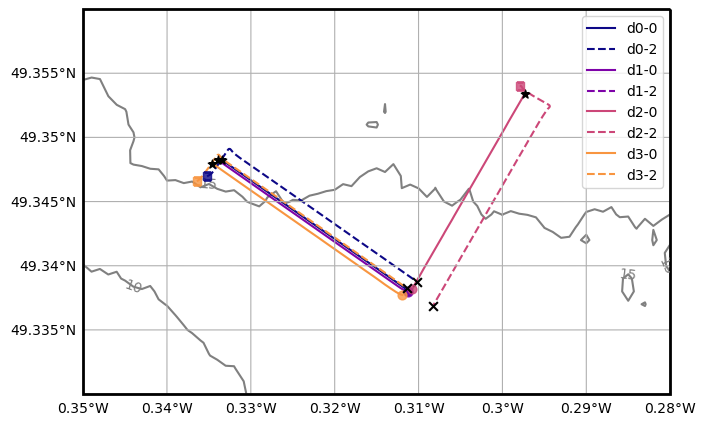

In [39]:
bounds = (-.35, -0.28, 49.33, 49.36)

fig, ax, cbar = cp.map(extent=bounds, rivers=False) # uses default yaml coastline and bathy

#for d, df in D.items():
for d, dtr in Rt.items():
    #df.plot(ax=ax, x="longitude", y="latitude", transform=crs, color=colors[d])
    for i, df in dtr.items():
        x, y = df.longitude, df.latitude
        ls = "-"
        if i==2:
            ls = "--"
        ax.plot(x, y, transform=crs, color=colors[d], label=f"{d}-{i}", ls=ls)
        if i==0 and x.size>0:
            ax.scatter(x.iloc[0], y.iloc[0], s=40, marker="o", color=colors[d], transform=crs, zorder=10, alpha=.8)
            ax.scatter(x.iloc[-1], y.iloc[-1], s=40, marker="*", color="k", transform=crs, zorder=10)
        if i==2 and x.size>0:
            ax.scatter(x.iloc[0], y.iloc[0], s=40, marker="s", color=colors[d], transform=crs, zorder=10, alpha=.8)
            ax.scatter(x.iloc[-1], y.iloc[-1], s=40, marker="x", color="k", transform=crs, zorder=10)
ax.legend()

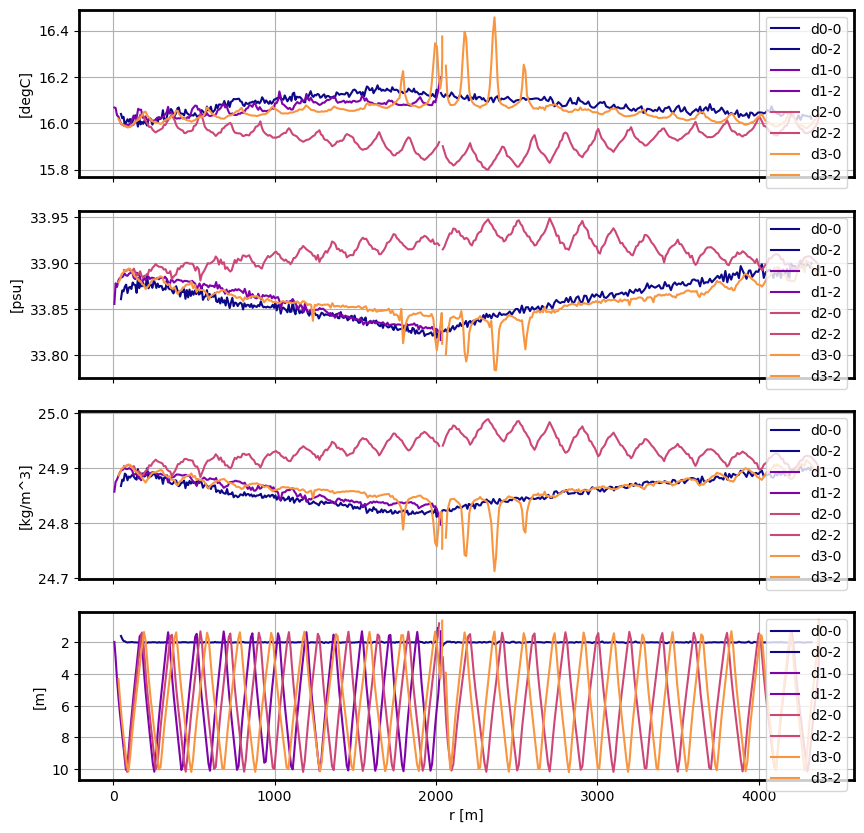

In [18]:
fig, axes = plt.subplots(4,1, figsize=(10,10))

ax = axes[0]
for d, dtr in Rt.items():
    for i, df in dtr.items():
        df["temperature"].plot(ax=ax, label=f"{d}-{i}", color=colors[d])
ax.grid()
ax.set_xlabel("")
ax.set_xticklabels("")
ax.set_ylabel("[degC]")
ax.legend()

ax = axes[1]
for d, dtr in Rt.items():
    for i, df in dtr.items():
        df["salinity"].plot(ax=ax, label=f"{d}-{i}", color=colors[d])
ax.grid()
ax.set_xlabel("")
ax.set_xticklabels("")
ax.set_ylabel("[psu]")
ax.legend()

ax = axes[2]
for d, dtr in Rt.items():
    for i, df in dtr.items():
        df["sigma0"].plot(ax=ax, label=f"{d}-{i}", color=colors[d])
ax.grid()
ax.set_xlabel("")
ax.set_xticklabels("")
ax.set_ylabel("[kg/m^3]")
ax.legend()

ax = axes[3]
for d, dtr in Rt.items():
    for i, df in dtr.items():
        df["depth"].plot(ax=ax, label=f"{d}-{i}", color=colors[d])
ax.grid()
ax.set_xlabel("r [m]")
ax.set_ylabel("[m]")
ax.legend()
ax.invert_yaxis()

### bin transects vertically

In [6]:
# should perform a linear regression instead in each group and use it to predict value at the center of the interval

def bin_horizontally_vertically(df):
    
    df = df.reset_index()

    # define bins
    dr = 200
    rbins = np.arange(-dr/2, df["r"].max()+dr, dr)
    dbins = np.arange(0.5, df.depth.max()+.5, 1)
    df["_depth"] = pd.cut(df["depth"], dbins)
    df["_r"] = pd.cut(df["r"], rbins)

    # bin
    dfb = df.groupby(["_r", "_depth"]).mean()
    dfb.loc[:, "r"] = dfb.reset_index()["_r"].apply(lambda i: i.mid).values
    dfb.loc[:, "depth"] = dfb.reset_index()["_depth"].apply(lambda i: i.mid).values
    ds = dfb.set_index(["r", "depth"]).to_xarray()
    
    ds = ds.assign_coords(z=-ds.depth)
    
    return ds

In [7]:

def plot_transect(ds, df):

    fig, axes = plt.subplots(3,1, figsize=(10,10))

    ax = axes[0]
    ds["temperature"].plot.contourf(ax=ax, x="r", y="z", levels=10, cmap=pin.maps.cm.thermal, corner_mask=False)
    #ds["temperature"].plot(ax=ax, x="r", y="z", cmap=pin.maps.cm.thermal)
    ax.scatter(df.index, -df.depth, color="k", s=0.5)
    ax.grid()
    ax.set_xlabel("")
    ax.set_xticklabels("")
    ax.set_ylabel("[m]")
    #for _, t in Rt[d].items():
    #    ax.axvline(t, color="w", lw=2)

    ax = axes[1]
    ds["salinity"].plot.contourf(ax=ax, x="r", y="z", levels=10, cmap=pin.maps.cm.haline)
    ax.scatter(df.index, -df.depth, color="k", s=0.5)
    ax.grid()
    ax.set_xlabel("")
    ax.set_xticklabels("")
    ax.set_ylabel("[m]")
    #for _, t in Rt[d].items():
    #    ax.axvline(t, color="w", lw=2)

    ax = axes[2]
    #ds["sigma0"].plot.contourf(ax=ax, x="r", y="z", levels=10, cmap=pin.maps.cm.dense)
    ds["legato_oxygen_concentration"].plot.contourf(ax=ax, x="r", y="z", levels=10, cmap=pin.maps.cm.dense)
    ax.scatter(df.index, -df.depth, color="k", s=0.5)
    ax.grid()
    ax.set_ylabel("[m]")
    #for _, t in Rt[d].items():
    #    ax.axvline(t, color="w", lw=2)
    

In [8]:
Ds = {d: bin_horizontally_vertically(D[d]) for d in ["d1", "d2", "d3"]}

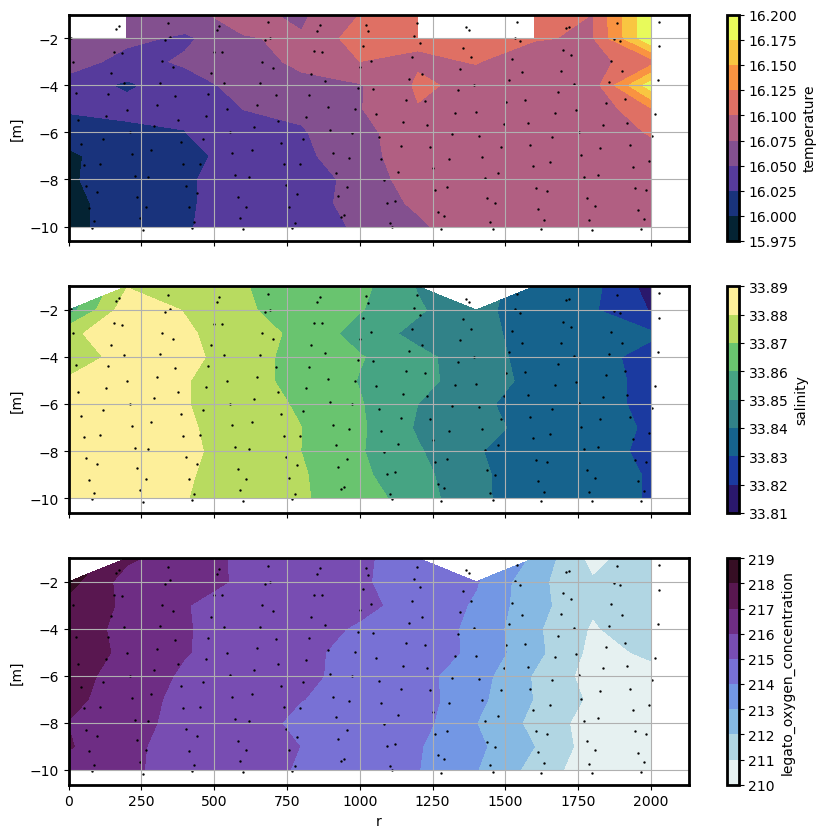

In [9]:
d = "d1"
plot_transect(Ds[d], D[d])

<Axes: xlabel='r'>

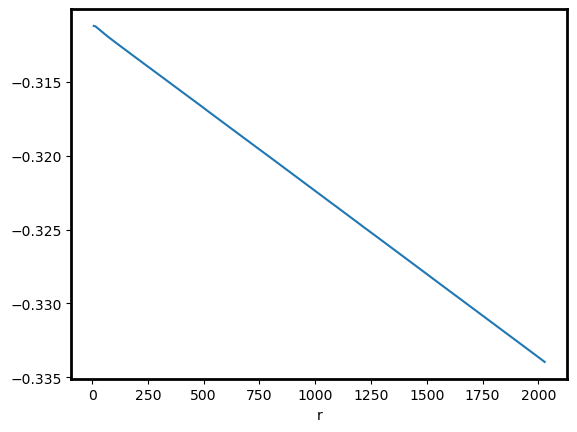

In [17]:
D[d]["longitude"].plot()

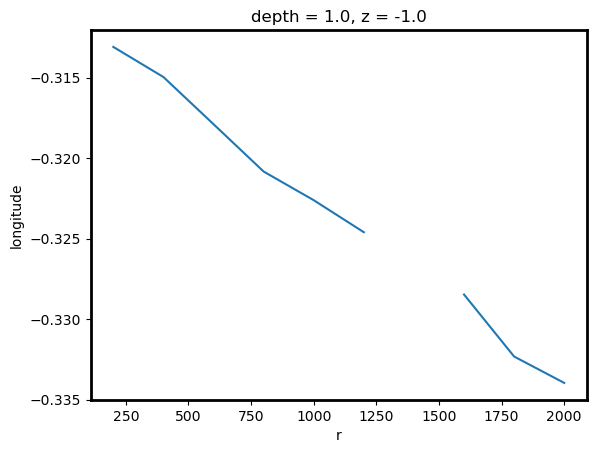

In [15]:
Ds[d]["longitude"].isel(depth=0).plot()

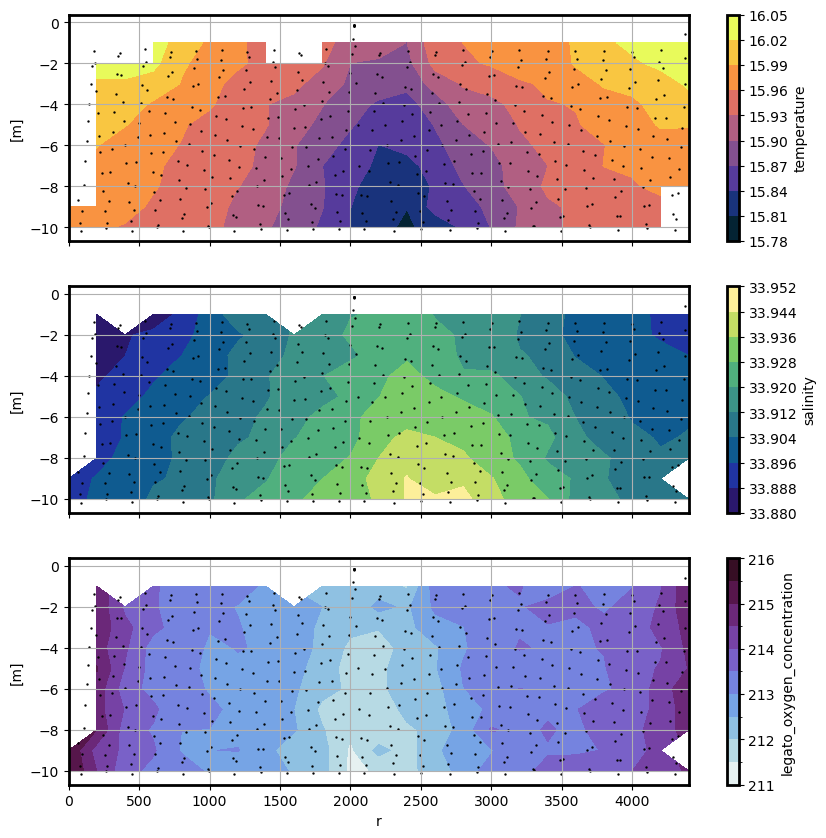

In [80]:
d = "d2"
plot_transect(Ds[d], D[d])

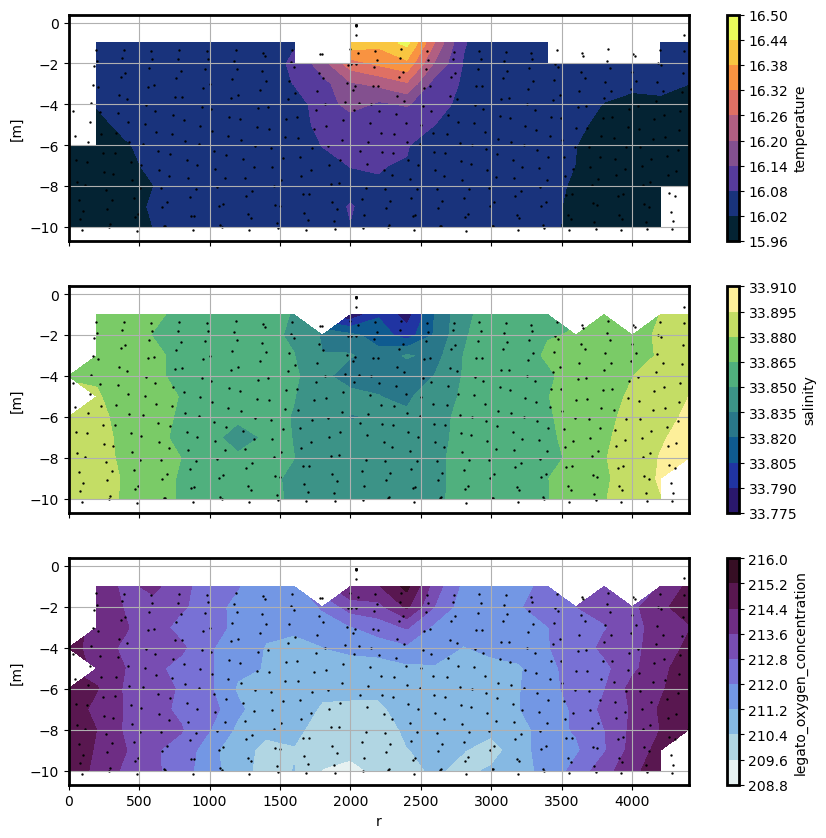

In [81]:
d = "d3"
plot_transect(Ds[d], D[d])

### plot full deployments

Text(0.5, 1.0, '')

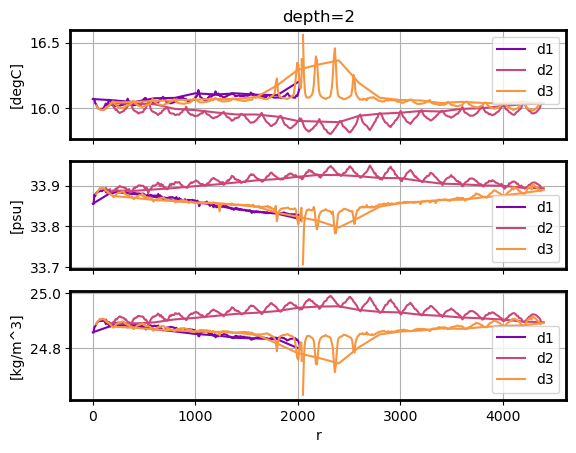

In [49]:
# select a depth level
depth = 2

fig, axes = plt.subplots(3,1,sharex=True)

ax = axes[0]
for d, ds in Ds.items():
    D[d]["temperature"].plot(ax=ax, label=d, color=colors[d])
    #ds["temperature"].plot.line(ax=ax, x="r", hue="depth")
    Ds[d].sel(depth=depth)["temperature"].plot.line(ax=ax, x="r", color=colors[d])
ax.grid()
ax.set_ylabel("[degC]")
ax.legend()
ax.set_title(f"depth={depth}")

ax = axes[1]
for d, ds in Ds.items():
    D[d]["salinity"].plot(ax=ax, label=d, color=colors[d])
    ds.sel(depth=depth)["salinity"].plot.line(ax=ax, x="r", color=colors[d])
ax.grid()
ax.set_ylabel("[psu]")
ax.legend()
ax.set_title("")

ax = axes[2]
for d, ds in Ds.items():
    D[d]["sigma0"].plot(ax=ax, label=d, color=colors[d])
    ds.sel(depth=depth)["sigma0"].plot.line(ax=ax, x="r", color=colors[d])
ax.grid()
ax.set_ylabel("[kg/m^3]")
ax.legend()
ax.set_title("")

---

## vertical casts

In [61]:
# should perform a linear regression instead in each group and use it to predict value at the center of the interval

def bin_vertically(df):
    
    df = df.reset_index().drop(columns="status")

    # define bins
    dbins = np.arange(0.5, df.depth.max(), 1)
    df["_depth"] = pd.cut(df["depth"], dbins)

    # bin
    dfb = df.groupby(["_depth"]).mean()
    dfb.loc[:, "depth"] = dfb.reset_index()["_depth"].apply(lambda i: i.mid).values
    ds = dfb.set_index("depth").to_xarray()
    
    ds = ds.assign_coords(z=-ds.depth)
    
    return ds

In [62]:
Dc = {d: bin_vertically(D[d]) for d in D if d[0]=="c"}

In [67]:
colors_c = {d: c for d, c in zip(Dc, pin.get_cmap_colors(len(Dc)))}

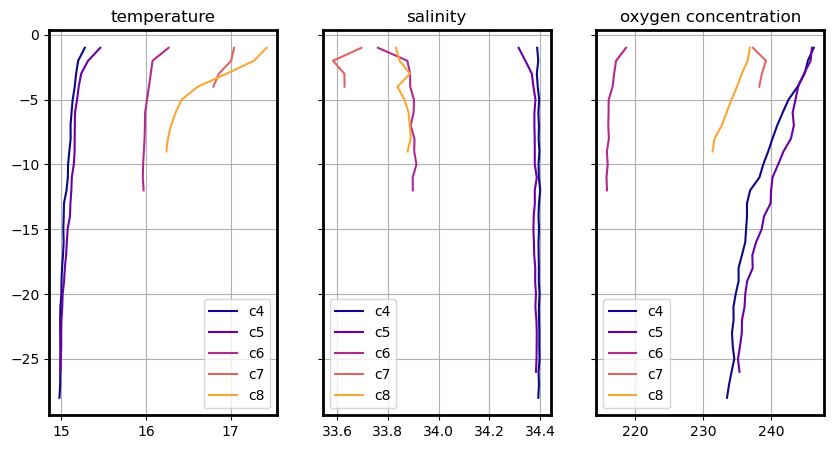

In [75]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(10,5))

ax = axes[0]
for d, ds in Dc.items():
    ax.plot(ds.temperature, -ds.depth, color=colors_c[d], label=d)
ax.grid()
ax.set_title("temperature")
ax.legend()

ax = axes[1]
for d, ds in Dc.items():
    ax.plot(ds.salinity, -ds.depth, color=colors_c[d], label=d)
ax.grid()
ax.set_title("salinity")
ax.legend()

ax = axes[2]
for d, ds in Dc.items():
    ax.plot(ds.legato_oxygen_concentration, -ds.depth, color=colors_c[d], label=d)
ax.grid()
ax.set_title("oxygen concentration")
ax.legend()


---

## dev material

In [ ]:
(
dfl["h_velocity"].hvplot(label="velocity", grid=True)
*dfl["x_velocity"].hvplot(label="x - velocity")
*dfl["y_velocity"].hvplot(label="y - velocity")
)

In [ ]:
# check depth
dfl["legato_depth"].hvplot()

In [ ]:
dfl["legato_temperature"].hvplot(grid=True)

In [ ]:
dfl["legato_salinity"].hvplot(grid=True)

<AxesSubplot: xlabel='longitude_gps', ylabel='latitude_gps'>

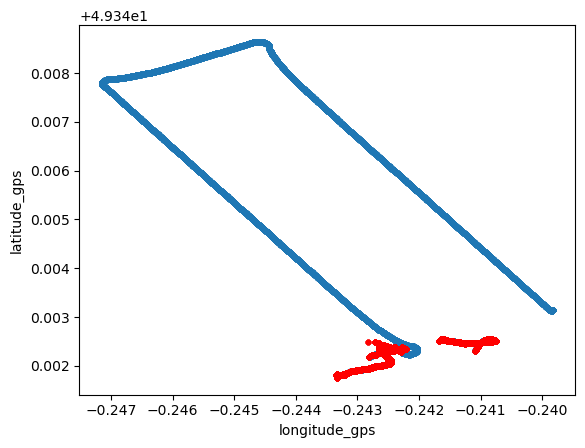

In [74]:
fig, ax = plt.subplots(1,1)

df.plot.scatter(ax=ax, x="longitude_ins", y="latitude_ins", s=10, marker="o")
df.plot.scatter(ax=ax, x="longitude_gps", y="latitude_gps", c="r", s=10, marker="P")